# Generative Deep Learning - Exploration

This is a notebook containing my exploration into the field of generative deep learning.

## Preliminary work

These linked notebook are preliminary work into various machine learning algorithms necessary to get the concept grounds covered:
- [Notebook 1]()
- [Notebook 2]()

## Introduction

The field of generative deep learning has always fascinated me (ever since I have seen the first [Google Deep Dream](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) examples, and the work of [Mario Klingemann](http://quasimondo.com/)), and saw an opportunity to deep dive into it while going into Semester 04 at CODE University. It developed into the first steps of research into an interactive installation done with artist [Diane Drubay](www.dianedrubay.com)

This being an ongoing project (outside of the semester scope), the final result will be available in a later period of time.

## Content 
1. [Deep learning](#Deep-learning)<br>
    1.1 [Load the cifar10 data](#Load-the-cifar10-data)<br>
    1.2 [Building](#Building-the-Model)<br>
    1.3 [Compiling](#Compiling-the-Model)<br>
    1.4 [Training](#Training-the-Model)<br>
    1.5 [Evaluating](#Evaluating-the-Model)<br>
    1.6 [Improving](#Improving-the-Model)<br>
2. [Autoencoder](#Autoencoder)
3. [Variational Autoencoder](#Variational-Autoencoder)
4. [GANs](#GANs)
5. [StyleGAN2 from Nvidia](#StyleGAN2)

# Deep-learning

This is the first real step into the direction of neural networks using keras. It can be considered as a warm-up.

In [1]:
import numpy as np

from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K#Variational-Autoencoder
from keras.utils import plot_model
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


# we have to use the experimental features in order to avoid a memory overflow of the GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Using TensorFlow backend.


## Load the cifar10 data

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 imagthees. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

It is noteworthy to tell that there are no <i>rows</i> or <i>columns</i> in this dataset, it's a <i>tensor</i> with four dimensions.

x_train, y_train are numpys arrays containing the image data <i>(32 x 32 px - 3 channel RGB colors)</i>

x_test, y_test are numpys arrays containing the integer labels in the range 0 to 9 for the class of each image.

In [ ]:
num_classes = 10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

A quick confirmation that the data shape is as expected to be

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

Showing the first 9 images of the dataset

In [ ]:
Autoencoders

Image data are integers between 255 and 0 - for the neural network we need a data range from -1 to 1

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

The integer labeling of the images needs to be changed into one-hot-encoded vectors. If the class integer label of an image is <i>i</i>, then its one-hot encoding is a vector of length 10 (num_classes) that has 0s in all but the <i>i</i>th element which is 1. The new shapes of y_train and y_test are therefore (50000, 10) and (10000, 10)

In [ ]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Building the Model

In Keras, there are two ways to define the structre of the neural network: a Sequential model or using the Functional API.

The Sequential model is used to create quickly a linear stack of layers. But we need networks with layers being able to pass data to multiple separate layers beneath it, or inversely, that a layer receives input from multiple layers above it.

Therefore the Functional API of Keras is being used to build the model.
We are using three different types of layer: <b>Input, Flatten, Dense</b>

The <b>Input</b> layer which is basically our entry point into the network. The network is being told the shape of each data element to expect as a tuple (32, 32, 3)

The <b>Flatten</b> layer which flattens our data into a vector of length 3072 (32 x 32 x 3). This is needed as the subsequent layer needs a flat input rather than a multidimensional array.

The <b>Dense</b> layer which is the most fundamental layer in any neural network. It contains a certain number of units densely connected by a single connection carrying a weight. The output from a given unit is the weighted sum of the input it receives from the previous layer, passed through an activation function ('relu') before being sent to the next layer. This activation function is critical to ensure the neural network can learn complex functions.


### Activation functions

An Activation function is a critical part of a neural network, ensuring the learning of complex functions. It is used to determine the output of the node, and is also known as Transfer Function.

- The <i>ReLU</i> activation function is defined to be zero if the input is negative and is otherwise equal to the input.
- The <i>LeakyReLU</i> activation function is almost the same as the ReLU, but returns a proportional negative number if the input is less than zero
- The <i>sigmoid</i> activation is useful for binary classification problems with one output unit or multilabel classification problems
- the <i>softmax</i> activation if one needs the total sum of the output from the layer to equal 1 (multiclass classification problems where each observation only belongs to exactly one class)

Right beneath is a visual indicator of the various types of activation functions

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x):
    return np.where(x > 0, x, x * 0.01)

def plot_zero_line(ax):
    return axes[ax].plot(np.zeros(len(x)), x, color='r')

x = np.arange(-5.0, 5.0, 0.1)

fig,axes=plt.subplots(nrows=1, ncols=4,figsize=(15#Variational-Autoencoder,5))

axes[0].plot(x, sigmoid(x), color='k', lw=1, ls='--')
plot_zero_line(0)
axes[0].set_title('Sigmoid')
axes[1].plot(x, relu(x), color='k', lw=1, linestyle='-.')
plot_zero_line(1)
axes[1].set_title('ReLU')
axes[2].plot(x, leaky_relu(x), color='k', lw=1)
plot_zero_line(2)
axes[2].set_title('Leaky ReLU')
axes[3].plot(x, softmax(x), color='k', lw=1, ls='-')
plot_zero_line(3)
axes[3].set_title('Softmax')

for ax in axes:
    ax.set_ylim(-0.1, 1.1)
fig.tight_layout()
plt.show()

This is our Model

In [ ]:
input_layer = Input(shape=(32, 32, 3))

x = Flatten()(input_layer)

x = Dense(units=200, activation='relu')(x)
x = Dense(units=150, activation='relu')(x)

output_layer = Dense(units=10, activation='softmax')(x)

model = Model(input_layer, output_layer)

## Compiling the Model

Here we compile the model with an optimizer (Adam) and a loss function.

The most commonly used loss functions are <i>mean squared loss</i> used to solve a regression problem (the output is continuous). If one is working on a classification problem where each observation only belongs to one class, use the <i>categorical cross-entropy</i>. And at last, if one is working on a binary classification problem with one output unit or a multilabel problem where each observation can belong to multiple classes, use <i>binary cross-entropy</i>


In [ ]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training the Model

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)

In [ ]:
model.summary()

## Evaluating the Model

The output of this method are categorical cross-entropy and accuracy on the test data (meaning the Model has never seen this data). The Model accuracy is around the same as with the training data.

In [ ]:
model.evaluate(x_test, y_test)

Below is a display of 10 randomly selected images with their predictions. We're on par with the accuracy, meaning that around 50% of the images are correctly labelled.

In [ ]:
def random_images_predictions():
    CLASSES = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    predictions = model.predict(x_test)
    predictions_single = CLASSES[np.argmax(predictions, axis=-1)]
    actuals_single = CLASSES[np.argmax(y_test, axis=-1)]

    num_to_show = 10
    indices = np.random.choice(range(len(x_test)), num_to_show)

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, idx in enumerate(indices):
        img = x_test[idx]
        ax = fig.add_subplot(1, num_to_show, i + 1)
        ax.axis('off')
        if (predictions_single[idx] == actuals_single[idx]):
            color = 'g'
        else:
            color = 'r'
        ax.text(0.5, -0.35, 'pred = ' + str(predictions_single[idx]), fontsize = 10, ha='center', transform=ax.transAxes, color=color)
        ax.text(0.5, -0.7, 'act = ' + str(actuals_single[idx]), fontsize = 10, ha='center', transform=ax.transAxes, color=color)
        ax.imshow(img)

In [ ]:
random_images_predictions()

## Improving the Model

The spatial structure of the pictures is not taken into account, hence the poor result. To get better result we can use <i>convolutional</i> layers.

### Convolutional layers
A convolution is the simple application of a filter to an input that results in an activation. Repeated application of the same filter to an input results in a map of activations called a feature map, indicating the locations and strength of a detected feature in an input, such as an image.


### Batch normalization

We want to ensure that the weights of the network remain within a reasonable range of values. If not, we will face the <i>exploding gradient</i> problem. One solution to that is to use a Batch Normalization layer. It calculates the mean and standard deviation of each of its input channel across the batch and normalizes by subtracting the mean and dividing by the standard deviation. We place them after dense or convolutional layers to normalize the output of those layers.

### Dropout layers

An additional step to avoid <i>overfitting</i> is to use dropout layers. A dropout layer chooses a random set of units from the preceding layers, and sets their output to zero. This ensures that our Model will be able to generalize on unseen data.

### The new Model

In [ ]:
input_layer = Input((32, 32, 3))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(num_classes)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

In [ ]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)

In [ ]:
model.summary()

In [ ]:
model.evaluate(x_test, y_test, batch_size=1000)

In [ ]:
random_images_predictions()

Using the convolutional layers greatly improved the accuracy of the Model. We went from around 50% to 72% of accuracy.

# Autoencoder

## Load the data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

## Define the structure of the neural network

In [3]:
input_dim = (28, 28, 1)
encoder_conv_filters = [32,64,64,64]
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [1,2,2,1]
decoder_conv_t_filters = [64,64,32,1]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [1,2,2,1]
z_dim = 2

use_batch_norm = False
use_dropout = False

n_layers_encoder = len(encoder_conv_filters)
n_layers_decoder = len(decoder_conv_t_filters)

## Encoder

In [4]:
encoder_input = Input(shape = input_dim, name = 'encoder_input')

In [5]:
x = encoder_input

for i in range(n_layers_encoder):
    conv_layer = Conv2D(
        filters = encoder_conv_filters[i],
        kernel_size = encoder_conv_kernel_size[i],
        strides = encoder_conv_strides[i],
        padding = 'same',
        name = 'encoder_conv_' + str(i))
    
    x = conv_layer(x) # Stack the convolutional layers on top of each other
    x = LeakyReLU()(x)
    
    if use_batch_norm:
        x = BatchNormalization()(x)
    if use_dropout:
        x = Dropout(rate = 0.25)(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x) # Flatten the last conv. layer to a vector

In [6]:
encoder_output = Dense(z_dim, name = 'encoder_output')(x)

In [7]:
encoder = Model(encoder_input, encoder_output)

In [8]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0   

## Decoder

In [9]:
decoder_input = Input(shape = (z_dim, ), name = 'decoder_input')

In [10]:
x = Dense(np.prod(shape_before_flattening))(decoder_input)

In [11]:
x = Reshape(shape_before_flattening)(x)

In [12]:
for i in range(n_layers_decoder):
    conv_t_layer = Conv2DTranspose(
        filters = decoder_conv_t_filters[i],
        kernel_size = decoder_conv_t_kernel_size[i],
        strides = decoder_conv_t_strides[i],
        padding = 'same',
        name = 'decoder_conv_t_' + str(i))
    
    x = conv_t_layer(x) # Stack the conv. transpose layers on top of each other
    
    if i < n_layers_decoder - 1:
        x = LeakyReLU()(x)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        if use_dropout:
            x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

In [13]:
decoder_output = x

In [14]:
decoder = Model(decoder_input, decoder_output)

In [15]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0   

## Joining the Encoder to the Decoder

In [16]:
model_input = encoder_input # The input to the autoencoder is the same as the input to the encoder
model_output = decoder(encoder_output) # The output from the autoencoder is the output from the encoder passed through the decoder

In [17]:
model = Model(model_input, model_output)

## Compilation

In [18]:
learning_rate = 0.0005
batch_size = 32
initial_epoch = 0

In [19]:
optimizer = Adam(lr = learning_rate)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])

model.compile(optimizer = optimizer, loss = r_loss)

## Training

In [22]:
model.fit(x = x_train,
          y = x_train,
          batch_size = batch_size,
          shuffle = True,
          epochs = 10,
          initial_epoch = initial_epoch)

Epoch 1/10
60000/60000 [==============================] - 12s 197us/step - loss: 0.0398
Epoch 2/10
60000/60000 [==============================] - 12s 201us/step - loss: 0.0397
Epoch 3/10
60000/60000 [==============================] - 11s 189us/step - loss: 0.0396
Epoch 4/10
60000/60000 [==============================] - 11s 183us/step - loss: 0.0395
Epoch 5/10
60000/60000 [==============================] - 12s 195us/step - loss: 0.0394
Epoch 6/10
60000/60000 [==============================] - 12s 199us/step - loss: 0.0393
Epoch 7/10
60000/60000 [==============================] - 12s 197us/step - loss: 0.0392
Epoch 8/10
60000/60000 [==============================] - 11s 189us/step - loss: 0.0392
Epoch 9/10
60000/60000 [==============================] - 11s 188us/step - loss: 0.0391
Epoch 10/10
60000/60000 [==============================] - 11s 188us/step - loss: 0.0390


## Analysing the results

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

### Reconstruction of the original images

In [24]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = encoder.predict(example_images)

reconst_images = decoder.predict(z_points)

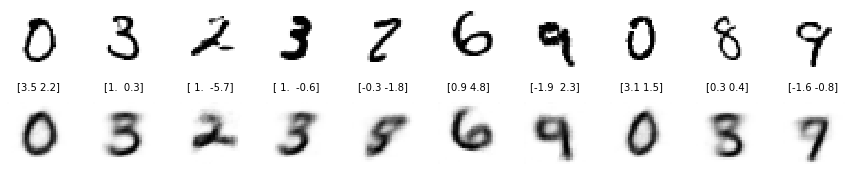

In [25]:
fig = plt.figure(figsize = (15, 3))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze() # Remove single-dimensional entries from the shape of an array.
    ax = fig.add_subplot(2, n_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i], 1)), fontsize = 10, ha = 'center', transform = ax.transAxes)
    ax.imshow(img, cmap = 'gray_r')
    
for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i + n_to_show + 1)
    ax.axis('off')
    ax.imshow(img, cmap = 'gray_r')

### Latent Space

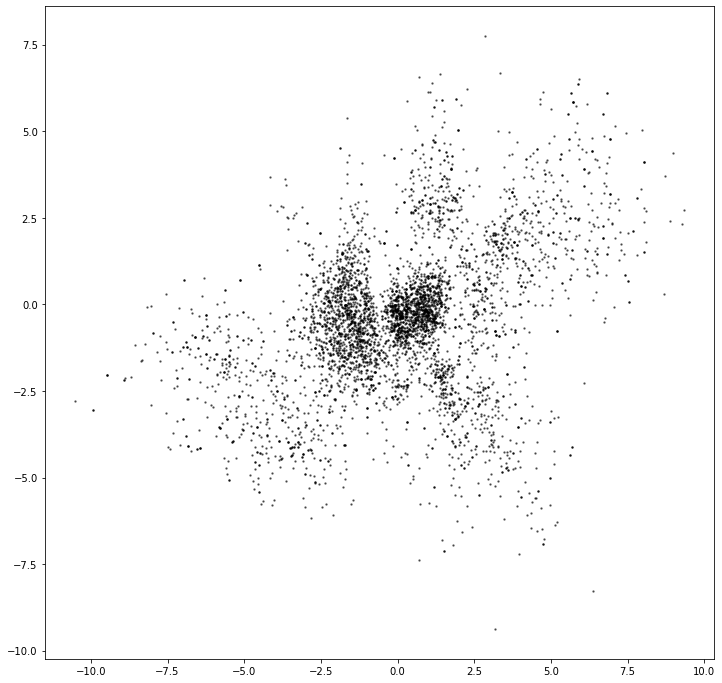

In [26]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c = 'black', alpha = 0.5, s = 2)
plt.show()

### Random sampling of the Latent Space

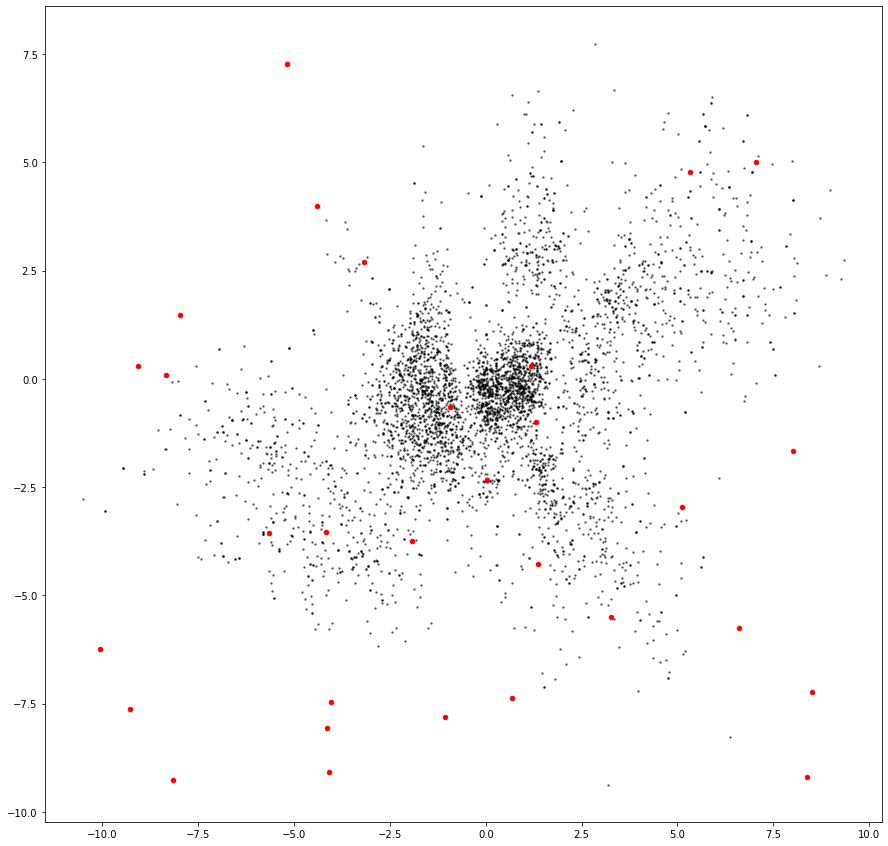

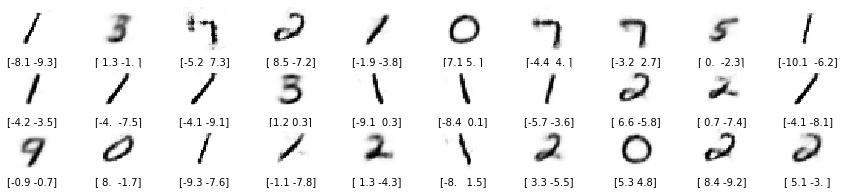

In [27]:
figsize = 15

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0], z_points[:, 1], c = 'black', alpha = 0.5, s = 2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x, max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y, max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = decoder.predict(z_grid)

plt.scatter(z_grid[:, 0], z_grid[:, 1], c = 'red', alpha = 1, s = 20)
plt.show()

fig = plt.figure(figsize = (figsize, grid_depth))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize = 10, ha = 'center', transform = ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

### Latent space sorted by digits

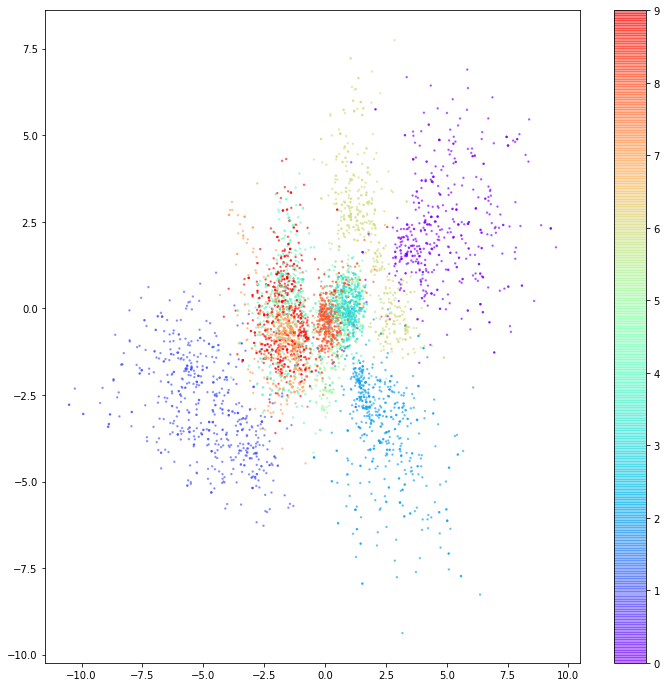

In [29]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)

plt.figure(figsize = (figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap ='rainbow' , c = example_labels, alpha = 0.5, s = 2)
plt.colorbar()
plt.show()

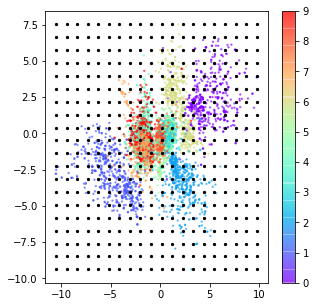

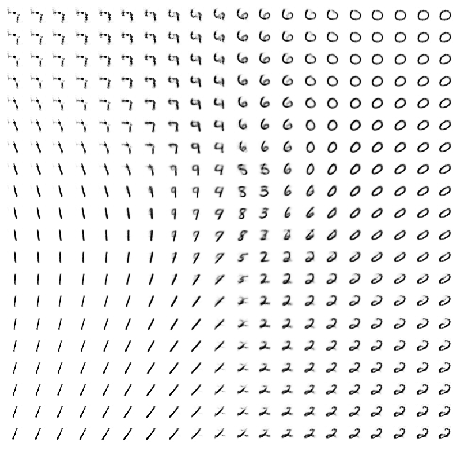

In [30]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0], z_points[:, 1] , cmap = 'rainbow' , c = example_labels, alpha = 0.5, s = 2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = decoder.predict(z_grid)

plt.scatter(z_grid[:, 0], z_grid[:, 1], c = 'black', alpha = 1, s = 5)#, cmap='rainbow' , c= example_labels

plt.show()

fig = plt.figure(figsize = (figsize, figsize))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i in range(grid_size ** 2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

# Variational Autoencoder

In an autoencoder, each image is mapped directly to one point in the latent space. 

In a variational autoencoder, each image is instead mapped to a multivariate normal distribution around a point in latent space.

To summarize, the encoder will take each input image and encode it to two vectors, <b>mu</b> and <b>log_var</b> which together define a multivariate normal distribution in the latent space.

<b>mu</b> - the mean point of the distribution
<br><b>log_var</b> - the logarithm of the variance of each dimension

To encode an image into a specific point <b>z</b> in the latent space, we can sample from this distribution, using the following equation:

z = mu + sigma * epsilon

sigma = exp(log_var / 2)

## Encoder

In [ ]:
x = encoder_input

for i in range(n_layers_encoder):
    conv_layer = Conv2D(
        filters = encoder_conv_filters[i],
        kernel_size = encoder_conv_kernel_size[i],
        strides = encoder_conv_strides[i],
        padding = 'same',
        name = 'encoder_conv_' + str(i))
    
    x = conv_layer(x) # Stack the convolutional layers on top of each other
    x = LeakyReLU()(x)
    
    if use_batch_norm:
        x = BatchNormalization()(x)
    if use_dropout:
        x = Dropout(rate = 0.25)(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x) # Flatten the last conv. layer to a vector

In [ ]:
mu = Dense(z_dim, name = 'mu')(x)
log_var = Dense(z_dim, name = 'log_var')(x)

In [ ]:
encoder_mu_log_var = Model(encoder_input, (mu, log_var))

In [ ]:
def sampling(args):
    mu, log_vars = args
    epsilon = K.random_normal(shape = K.shape(mu), mean = 0., stddev = 1.)
    return mu * K.exp(log_var / 2) * epsilon

In [ ]:
encoder_output = Lambda(sampling, name = 'encoder_output')([mu, log_var])

In [ ]:
encoder = Model(encoder_input, encoder_output)

In [ ]:
encoder.summary()

## Decoder

The decoder is identical to the Autoencoder, the only thing needed to be changed is the loss function.

The loss function in the Autoencoder is a RMSE function. It's the same in a VAE but we need an additional component: the <i>Kullback-Leibler(KL) divergence.</i>

KL divergence is a way of measuring how much one probability distribution differs from another. In a VAE we want to measure how different our normal distribution with parameters <b>mu</b> and <b>log_var</b> is from the standard normal distribution.

The KL divergence term penalizes the network for encoding observations to <b>mu</b> and <b>log_var</b> variables that differ significantly from the parameters of a standard normal distribution, namely <b>mu = 0</b> and <b>log_var = 0</b>

In [ ]:
decoder_input = Input(shape = (z_dim, ), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

for i in range(n_layers_decoder):
    conv_t_layer = Conv2DTranspose(
        filters = decoder_conv_t_filters[i],
        kernel_size = decoder_conv_t_kernel_size[i],
        strides = decoder_conv_t_strides[i],
        padding = 'same',
        name = 'decoder_conv_t_' + str(i))
    
    x = conv_t_layer(x) # Stack the conv. transpose layers on top of each other
    
    if i < n_layers_decoder - 1:
        x = LeakyReLU()(x)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        if use_dropout:
            x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

decoder_output = x

decoder = Model(decoder_input, decoder_output)
model = Model(model_input, model_output)

In [ ]:
learning_rate = 0.0005
batch_size = 32
initial_epoch = 0
r_loss_factor = 1000

In [ ]:
optimizer = Adam(lr = learning_rate)

def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])
    return r_loss_factor * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.sum(1 * log_var - K.square(mu) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return r_loss * kl_loss

model.compile(optimizer = optimizer, loss = vae_loss, metrics = [vae_r_loss, vae_kl_loss])

In [2]:
model.fit(x = x_train,
          y = x_train,
          batch_size = batch_size,
          shuffle = True,
          epochs = 200,
          initial_epoch = initial_epoch)

# GANs

# StyleGAN2